In [1]:
%matplotlib inline

In [2]:
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
from gammapy.irf import load_cta_irfs
from gammapy.maps import WcsGeom, MapAxis
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    GaussianSpatialModel,
    SkyModel,
    Models,
    FoVBackgroundModel,
)
from gammapy.makers import MapDatasetMaker, SafeMaskMaker
from gammapy.modeling import Fit
from gammapy.datasets import Datasets, MapDataset
from gammapy.data import Observation, observatory_locations
from regions import CircleSkyRegion
from scipy.stats import chi2, norm

import matplotlib.pyplot as plt
from IPython.display import display
from gammapy.analysis import Analysis, AnalysisConfig
from gammapy.estimators import ExcessMapEstimator
from gammapy.modeling import Fit
from gammapy.catalog import CATALOG_REGISTRY, SourceCatalogHGPS

In [3]:
!gammapy info --no-envvar --no-dependencies --no-system


Gammapy package:

	version                : 0.20.1     
	path                   : D:\Documents\Miniconda\envs\gammapy-0.20.1\lib\site-packages\gammapy 



In [4]:
print(CATALOG_REGISTRY)
catalog=SourceCatalogHGPS()
source = catalog[3]

model = source.sky_model()
print(model)

Registry
--------

SourceCatalogGammaCat: gamma-cat 
SourceCatalogHGPS    : hgps 
SourceCatalog2HWC    : 2hwc 
SourceCatalog3FGL    : 3fgl 
SourceCatalog4FGL    : 4fgl 
SourceCatalog2FHL    : 2fhl 
SourceCatalog3FHL    : 3fhl 
SourceCatalog3HWC    : 3hwc 

SkyModel

  Name                      : HESS J1018-589 B
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : GaussianSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.196   +/-    0.09             
    amplitude                     :   9.15e-14   +/- 1.1e-14 1 / (cm2 s TeV)
    reference             (frozen):      2.742       TeV         
    lon_0                         :    284.223   +/-    0.04 deg         
    lat_0                         :     -1.772   +/-    0.03 deg         
    sigma                         :      0.150   +/-    0.03 deg         
    e                     (frozen):      0.000                  

In [5]:
# Loading IRFs
irfs = load_cta_irfs(
    "$GAMMAPY_DATA/cta-1dc/caldb/data/cta/1dc/bcf/South_z20_50h/irf_file.fits"
)

Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)


In [6]:
# Define the observation parameters (typically the observation duration and the pointing position):
livetime = 6.0 * u.hr
pointing = SkyCoord(283, 0, unit="deg", frame="galactic")

In [7]:
# Define map geometry for binned simulation
energy_reco = MapAxis.from_edges(
    np.logspace(-1.0, 1.0, 10), unit="TeV", name="energy", interp="log"
)
geom = WcsGeom.create(
    skydir=(283, 0),
    binsz=0.02,
    width=(6, 6),
    frame="galactic",
    axes=[energy_reco],
)
# It is usually useful to have a separate binning for the true energy axis
energy_true = MapAxis.from_edges(
    np.logspace(-1.5, 1.5, 30), unit="TeV", name="energy_true", interp="log"
)

empty = MapDataset.create(
    geom, name="dataset-simu", energy_axis_true=energy_true
)

In [8]:
# Create an in-memory observation
location = observatory_locations["cta_south"]
obs = Observation.create(
    pointing=pointing, livetime=livetime, irfs=irfs, location=location
)
print(obs)

Observation

	obs id            : 0 
 	tstart            : 51544.00
	tstop             : 51544.25
	duration          : 21600.00 s
	pointing (icrs)   : 154.4 deg, -56.8 deg

	deadtime fraction : 0.0%



In [9]:
# Make the MapDataset
maker = MapDatasetMaker(selection=["exposure", "background", "psf", "edisp"])

maker_safe_mask = SafeMaskMaker(methods=["offset-max"], offset_max=4.0 * u.deg)

In [10]:
def simulate_range(model,radlist):
    list_model=[]
    model.parameters["lon_0"].min=280
    model.parameters["lon_0"].max=286
    model.parameters["lat_0"].min=-3
    model.parameters["lat_0"].max=3
    for i in range(len(radlist)):
        list_model.append(model.copy())
        list_model[i].parameters["sigma"].value=radlist[i]
    return list_model

In [11]:
size=[0.1, 0.3, 0.5, 0.7, 0.9]

In [12]:
def fit_dataset(model,vary_bkg=False):
    
    dataset = maker.run(empty, obs)
    dataset = maker_safe_mask.run(dataset, obs)
 
    bkg_model = FoVBackgroundModel(dataset_name="dataset-simu")
    if vary_bkg==True:
        bkg_model.spectral_model.norm.value = np.random.normal(1,0.1)
        bkg_model.spectral_model.tilt.value = np.random.normal(0,0.05)
        
    # A faint diffuse background
    #diffuse_spec = PowerLawSpectralModel()
    #diffuse_spec.index.value = 2.7
    #diffuse_spec.amplitude.value = 1e-13
    #diffuse_spat = GaussianSpatialModel()
    #diffuse_spat = GaussianSpatialModel(frame="galactic")
    #diffuse_spat.sigma.value = 1.0
    #diffuse_spat.e.value = 0.99999
    #diffuse_spat.phi.value = 90
    #diffuse_model = SkyModel(spectral_model=diffuse_spec,
    #                         spatial_model=diffuse_spat,
    #                         name="diffuse")
        
    dataset.models =  Models([bkg_model, model])
    dataset.fake()
    # -- like an observation
    
    dataset.models = Models([bkg_model]) #  background + diffuse
    fit = Fit(optimize_opts={"print_level": 1})
    result = fit.run(datasets=dataset)
    L0 = result.total_stat
    print(L0)
   
    dataset.models = Models([bkg_model, model])
    fit = Fit(optimize_opts={"print_level": 1})
    result = fit.run(datasets=dataset)
    L1 = result.total_stat
    print(L1)
    return L0-L1, result, dataset

In [13]:
sigma=[]
simsize=[]
recsize=[]
recsizeerr=[]
amprecon=[]
ampreconerr=[]

In [55]:
models=[]
TS = []
datasets = []
list_model=simulate_range(model,size)
for i in range(len(list_model)):
    delt, mod, ds = fit_dataset(list_model[i],vary_bkg=True) 
    models.append(mod)
    TS.append(delt)
    datasets.append(ds)

609041.2236139533
608647.0064764974
629129.4877878819
629010.9958719974
659359.5385025595
W DavidonErrorUpdator delgam < 0 : first derivatives increasing along search line
W VariableMetricBuilder Matrix not pos.def, gdel = 0.000371693 > 0
W MnPosDef Matrix forced pos-def by adding to diagonal 3.03614
W VariableMetricBuilder gdel = -0.000933504
W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Machine accuracy limits further improvement
659331.0412557647
621776.0455954075
W VariableMetricBuilder Reached machine accuracy limit; Edm 0.00131777 is smaller than machine limit 0.0370597 while 0.0002 was requested
621758.6222920594
663406.0633439164
W DavidonErrorUpdator delgam < 0 : first derivatives increasing along search line
W VariableMetricBuilder Matrix not pos.def, gdel = 68.4034 > 0
W MnPosDef non-positive diagonal element in covariance matrix[ 5 ] = -2.57827
W MnPosDef Added to diagonal of Error matrix a value 3.07827
W MnPosDef Matrix forced pos-def by ad

In [56]:
for _ in models:
    print(_.parameters.to_table())

  type      name      value         unit      ...    max    frozen is_norm link
-------- --------- ----------- -------------- ... --------- ------ ------- ----
spectral      norm  9.7006e-01                ...       nan  False    True     
spectral      tilt  1.3350e-02                ...       nan   True   False     
spectral reference  1.0000e+00            TeV ...       nan   True   False     
spectral     index  2.2322e+00                ...       nan  False   False     
spectral amplitude  7.3276e-14 cm-2 s-1 TeV-1 ...       nan  False    True     
spectral reference  2.7416e+00            TeV ...       nan   True   False     
 spatial     lon_0  2.8422e+02            deg ... 2.860e+02  False   False     
 spatial     lat_0 -1.7720e+00            deg ... 3.000e+00  False   False     
 spatial     sigma  8.7905e-02            deg ...       nan  False   False     
 spatial         e  0.0000e+00                ... 1.000e+00   True   False     
 spatial       phi  0.0000e+00          

In [57]:
def sigma_to_ts(sigma, df=1):
    """Convert sigma to delta ts"""
    p_value = 2 * norm.sf(sigma)
    return chi2.isf(p_value, df=df)

def ts_to_sigma(ts, df=1):
    """Convert delta ts to sigma"""
    p_value = chi2.sf(ts, df=df)
    return norm.isf(0.5 * p_value)
for i in range(len(TS)):
    sigma.append(ts_to_sigma(TS[i],6))
print(sigma)

[21.85348737647503, 9.827030774762498, 4.0741299296349816, 3.5872978157827484, 3.1817587614585823, 20.726365925654488, 6.771843575197062, 5.859849426499171, 3.5881758126545353, 1.9733099562126475, 18.749332070874953, 9.799707757106216, 4.356623864023246, 5.01115245585429, 0.0, 20.200173455268796, 7.86117319709517, 4.382237128518858, 4.123676049980744, 0.8301642863253037, 19.185484934792544, 9.92084822004648, 3.9575654453181084, 2.6585747649676468, 2.0813041022143652]


In [58]:
for i in range(len(size)):   
    simsize.append(size[i])
for _ in models:
    recsize.append(_.models[1].parameters["sigma"].value)
    recsizeerr.append(_.models[1].parameters["sigma"].error)
    amprecon.append(_.models[1].parameters["amplitude"].value)
    ampreconerr.append(_.models[1].parameters["amplitude"].error)
ratio=[]
ratioerr=[]
for i in range(len(simsize)):
    ratio.append(recsize[i]/simsize[i])
    ratioerr.append(recsizeerr[i]/simsize[i])


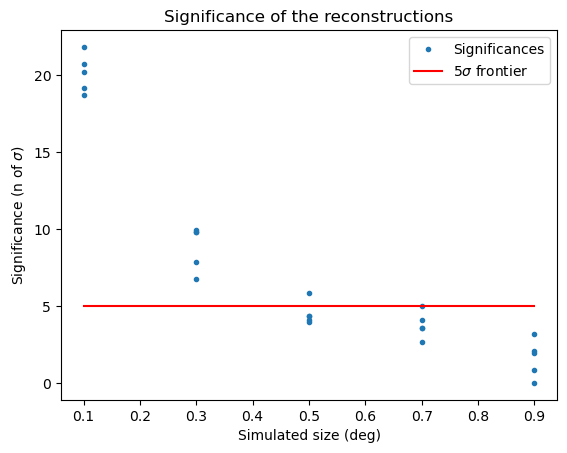

In [59]:
plt.plot(simsize,sigma,'.',label="Significances")
plt.plot([0.1,0.9],[5,5],"-r",label=r"5$\sigma$ frontier")
plt.title('Significance of the reconstructions')
plt.xlabel('Simulated size (deg)')
plt.ylabel(r'Significance (n of $\sigma$)')
plt.legend()
plt.show()

In [60]:
ratio

[1.0321344196469253,
 1.1051273889164939,
 0.8402206364949341,
 0.9844666313629679,
 2.6214185569393513,
 0.9865680344044305,
 0.8198420747969014,
 0.8455006573211975,
 0.5636186193828691,
 1.371733879195767,
 0.8930385089122395,
 0.937655845362026,
 0.8560665048183117,
 1.47605577627138,
 1.0828364766349698,
 1.0532331506102137,
 1.0440947385802928,
 0.970515527017549,
 0.756839181267055,
 0.2482040714751345,
 0.8790492240788955,
 0.9015737057104299,
 1.11220943489819,
 1.5581665475352269,
 0.5498706626491537]

In [61]:
sigma

[21.85348737647503,
 9.827030774762498,
 4.0741299296349816,
 3.5872978157827484,
 3.1817587614585823,
 20.726365925654488,
 6.771843575197062,
 5.859849426499171,
 3.5881758126545353,
 1.9733099562126475,
 18.749332070874953,
 9.799707757106216,
 4.356623864023246,
 5.01115245585429,
 0.0,
 20.200173455268796,
 7.86117319709517,
 4.382237128518858,
 4.123676049980744,
 0.8301642863253037,
 19.185484934792544,
 9.92084822004648,
 3.9575654453181084,
 2.6585747649676468,
 2.0813041022143652]

In [62]:
ampreconerr

[8.204259171819276e-15,
 1.6917784409502167e-14,
 1.9119784184775375e-14,
 4.008658338172141e-14,
 1.9829780693124785e-14,
 7.55414690234668e-15,
 1.4025551701044012e-14,
 2.074509128778579e-14,
 2.062871656801223e-14,
 7.442855008825515e-13,
 7.59976686279494e-15,
 1.4847933611453248e-14,
 2.6195099685112418e-14,
 6.998197071567026e-14,
 3.071057940848736e-13,
 8.180626674233353e-15,
 1.706853842130328e-14,
 2.6610918150230458e-14,
 3.650937919292216e-14,
 1.405066028017436e-14,
 7.48520345619724e-15,
 1.3470659450216458e-14,
 2.6436059281261532e-14,
 7.195323785479648e-14,
 4.222932556508628e-14]

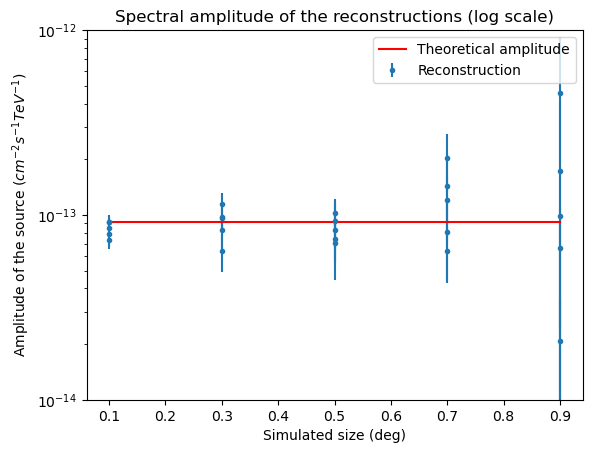

In [63]:
theoamp=model.parameters["amplitude"].value
plt.yscale('log')
plt.errorbar(simsize,amprecon,yerr=ampreconerr,fmt='.',label='Reconstruction')
plt.plot([0.1,0.9],[theoamp,theoamp],'-r',label='Theoretical amplitude')
plt.ylim(1e-14,1e-12)
plt.title('Spectral amplitude of the reconstructions (log scale)')
plt.xlabel('Simulated size (deg)')
plt.ylabel('Amplitude of the source '+r'($cm^{-2} s^{-1} TeV^{-1}$)')
plt.legend()
plt.show()

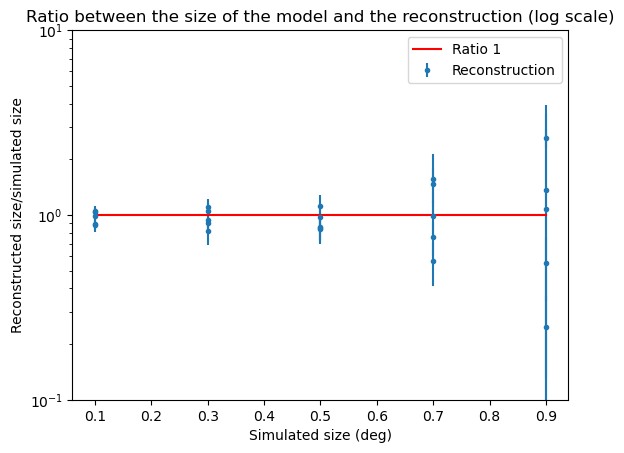

In [64]:
plt.yscale('log')
plt.errorbar(simsize,ratio,yerr=ratioerr,fmt='.',label='Reconstruction')
plt.plot([0.1,0.9],[1,1],'-r',label='Ratio 1')
plt.ylim(0.1,10)
plt.title('Ratio between the size of the model and the reconstruction (log scale)')
plt.xlabel('Simulated size (deg)')
plt.ylabel('Reconstructed size/simulated size')
plt.legend()
plt.show()